In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
#from datetime import datetime
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use('seaborn-notebook')
from scipy import stats
import math
import os
from dateutil.parser import parse
from datetime import datetime, date, time
import calendar
from datetime import timedelta

In [2]:
#Data loading
dataset2 = pd.read_excel(open('Online Retail.xlsx','rb'), sheet_name='Online Retail')


In [3]:
#Downsampling if needed
dataset = dataset2#[:5000]
dataset.shape

(541909, 8)

In [4]:
#Create a sub-sample
#dataset.to_csv('ordersample.csv')

In [5]:
#We sort the dataset and check the time range
dataset = dataset.sort_values('InvoiceDate')
print('First order', dataset['InvoiceDate'].min())
print('Last order', dataset['InvoiceDate'].max())

First order 2010-12-01 08:26:00
Last order 2011-12-09 12:50:00


In [6]:
#Day 1 definition
today = datetime(2012,1,1,0,0)

In [7]:
#We mark the cancelled invoices
dataset['Cancelled'] = dataset['InvoiceNo'].apply(lambda x: 1 if str(x).startswith('C') else 0)
dataset[dataset['Cancelled'] == 1].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1


In [8]:
#We keep only the info from UK
dataset = dataset[dataset['Country'] == 'United Kingdom']
dataset.shape

(495478, 9)

In [9]:
#We drop the duplicates
dataset = dataset.drop_duplicates()
dataset.shape

(490300, 9)

In [10]:
#We drop the fields with no customer ID
dataset = dataset.dropna(axis = 0, how = 'any', subset = ['CustomerID'])
dataset.shape

(356728, 9)

In [11]:
#Any odd values ?
dataset.describe()

,Quantity,UnitPrice,CustomerID,Cancelled
count,356728.000000,356728.000000,356728.000000,356728.000000
mean,11.198644,3.268255,15543.795284,0.021027
std,264.998044,71.162330,1594.286219,0.143475
min,-80995.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,14191.000000,0.000000
50%,4.000000,1.950000,15513.000000,0.000000
75%,12.000000,3.750000,16931.000000,0.000000
max,80995.000000,38970.000000,18287.000000,1.000000


In [12]:
#We clean all the weird Stockcodes

#drop all the that are extra fees
extrafeereasons = ['POST', 'DOT', 'C2',
                   'CRUK', 'M', 'BANK CHARGES', 'PADS', 'D']
for todrop in extrafeereasons:
    dataset = dataset[dataset['StockCode'] != todrop]
dataset.shape


(356110, 9)

In [13]:
dataset = dataset[dataset['UnitPrice'] != 0.00]
dataset.shape

(356090, 9)

In [14]:
#We clean the quantity < 0 and invoice not cancelled
#dataset = 
dataset[(dataset['Quantity'] < 0) & (dataset['Cancelled'] == 0)]
#dataset.shape

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


In [15]:
#No free stuff in the dataset, must cost at least 1 penny
dataset = dataset[dataset['UnitPrice'] >= 0.01]
dataset.shape

(356090, 9)

In [16]:
#Any np.nan remaining ?
dataset.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Cancelled      0
dtype: int64

In [17]:
#Totat per item
dataset['TotalItem'] = dataset['UnitPrice'] * dataset['Quantity']
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


In [18]:
#initial price calculation
initpricedict = dataset[['UnitPrice', 'StockCode']].groupby('StockCode')['UnitPrice'].first().to_dict()
dataset['Initprice'] = dataset['StockCode'].apply(lambda x : initpricedict[x])
dataset['ItemDiscount'] = dataset['Initprice'] / dataset['UnitPrice']
dataset['TotalItemInit'] = dataset['Initprice'] * dataset['Quantity']
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34


In [19]:
#Savings calculation
dataset['Savings'] = dataset['TotalItem'] - dataset['TotalItemInit']
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0


In [20]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0


In [21]:
#We split the unit prices by quantile
classes = 5

#### CALULATION BEGINNING ####
divider = 100/classes

price = dataset[['StockCode', 'UnitPrice']].groupby('StockCode').first()

price['QuantUnitPrice'] = price['UnitPrice'].apply(lambda x: math.ceil(stats.percentileofscore(price['UnitPrice'],x, kind = 'mean')/divider))
price[['UnitPrice', 'QuantUnitPrice']].head()


pricedictquant = price['QuantUnitPrice'].to_dict()

dataset['QuantUnitPrice'] = dataset['StockCode'].apply(lambda x: pricedictquant.get(x, 0))

dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings,QuantUnitPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0,4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4


In [22]:
#quant unit price vectorization - dollars

temp = dataset.pivot(columns='QuantUnitPrice', values='TotalItem').fillna(0)
new_names = [(i, 'QuantUnitPrice_{:02d}'.format(i)) for i in temp.columns.values]
temp.rename(columns = dict(new_names), inplace=True)
temp.head()
dataset = dataset.merge(temp, how='inner', left_index=True, right_index=True)
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings,QuantUnitPrice,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0,3,0.0,0.0,15.3,0.00,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4,0.0,0.0,0.0,20.34,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0,4,0.0,0.0,0.0,22.00,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4,0.0,0.0,0.0,20.34,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4,0.0,0.0,0.0,20.34,0.0


In [23]:
#quant unit price savings vectorization - savings

temp = dataset.pivot(columns='QuantUnitPrice', values='Savings').fillna(0)
new_names = [(i, 'QuantUnitSavings_{:02d}'.format(i)) for i in temp.columns.values]
temp.rename(columns = dict(new_names), inplace=True)
temp.head()
dataset = dataset.merge(temp, how='inner', left_index=True, right_index=True)
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,...,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,...,0.0,0.0,15.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,...,0.0,0.0,0.0,22.00,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Amount cancelled
dataset['AmountCancelled'] = dataset['Cancelled'] * dataset['TotalItem']

dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,...,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,AmountCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,...,0.0,15.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,...,0.0,0.0,22.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
dataset.CustomerID.unique()

array([ 17850.,  13047.,  13748., ...,  15520.,  13298.,  14569.])

In [26]:
#Invoicedb calculation

def my_agg(x):
    aggcalcul = {
        'InvoiceDate': x['InvoiceDate'].min(),
        'TotalInvoice': x['TotalItem'].sum(),
        'TotalInvoiceInit': x['TotalItemInit'].sum(),
        'CustomerID':  x['CustomerID'].min(),
        'TotalSavings': x['Savings'].sum(),
        'AmountCancelled' : x['AmountCancelled'].sum(),
        }
    return pd.Series(aggcalcul, index=aggcalcul.keys())
invoicedb = dataset.groupby('InvoiceNo').apply(my_agg).fillna(0)

invoicedb.head()


,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled
InvoiceNo,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0


In [27]:
#detail orders for invoicedb - QUANT UNIT PRICE
detail = [x for x in dataset.columns.values if x.startswith('QuantUnitPrice_')]
detail.append('InvoiceNo')
temp = dataset[detail].groupby('InvoiceNo').sum()
temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05
InvoiceNo,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85


In [28]:
#detail orders for invoicedb - QUANT UNIT SAVINGS
detail = [x for x in dataset.columns.values if x.startswith('QuantUnitSavings_')]
detail.append('InvoiceNo')
temp = dataset[detail].groupby('InvoiceNo').sum()
temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05
InvoiceNo,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30,0.0,0.0,0.0,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05,0.0,0.0,0.0,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55,0.0,0.0,0.0,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85,0.0,0.0,0.0,0.0,0.0


In [29]:
#Invoicedb updates

#Day between orders calculation
invoicedb = invoicedb.sort_values('InvoiceDate')
invoicedb['Ordersep'] = invoicedb[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).InvoiceDate.apply(lambda x: x.diff()).fillna(0)
invoicedb['Ordersep'] = invoicedb['Ordersep'].apply(lambda x: x.days)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,Ordersep
InvoiceNo,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30,0.0,0.0,0.0,0.0,0.0,0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05,0.0,0.0,0.0,0.0,0.0,0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55,0.0,0.0,0.0,0.0,0.0,0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85,0.0,0.0,0.0,0.0,0.0,0


In [30]:
#InvoiceDB discount
invoicedb['Discount'] = invoicedb['TotalInvoice'] / invoicedb['TotalInvoiceInit']
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,Ordersep,Discount
InvoiceNo,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30,0.0,0.0,0.0,0.0,0.0,0,1.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,1.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05,0.0,0.0,0.0,0.0,0.0,0,1.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55,0.0,0.0,0.0,0.0,0.0,0,1.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85,0.0,0.0,0.0,0.0,0.0,0,1.0


In [31]:
#When the order has been placed during the day in pounds?

def daysplit(x):
    hour = x.hour
    if 6 < hour < 12:
        return 1
    elif 12 <= hour < 20:
        return 2
    else:
        return 3

invoicedb['Daytime'] = invoicedb['InvoiceDate'].apply(daysplit)
    
temp = invoicedb.pivot(columns='Daytime', values='TotalInvoice').fillna(0)
new_names = [(i, 'Daytime_Monetary_'+str(i)) for i in temp.columns.values]
temp.rename(columns = dict(new_names), inplace=True)
#temp = pd.get_dummies(invoicedb['InvoiceDate'].map(daysplit), prefix = 'Daytime')
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,...,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,Ordersep,Discount,Daytime,Daytime_Monetary_1,Daytime_Monetary_2,Daytime_Monetary_3
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,...,0.0,0.0,0.0,0.0,0,1.0,1,139.12,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,...,0.0,0.0,0.0,0.0,0,1.0,1,22.20,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,...,0.0,0.0,0.0,0.0,0,1.0,1,278.73,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,...,0.0,0.0,0.0,0.0,0,1.0,1,70.05,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0,1.0,1,17.85,0.0,0.0


In [32]:
#When the order has been placed during the week in pounds?
def daysplit(x):
    day = x.weekday()
    return 'Weekday_{}_{}'.format(day, list(calendar.day_name)[day])
    #return day

invoicedb['Weekday'] = invoicedb['InvoiceDate'].map(daysplit)
temp = invoicedb.pivot(columns='Weekday', values='TotalInvoice').fillna(0)
#temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()



,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,...,Daytime_Monetary_1,Daytime_Monetary_2,Daytime_Monetary_3,Weekday,Weekday_0_Monday,Weekday_1_Tuesday,Weekday_2_Wednesday,Weekday_3_Thursday,Weekday_4_Friday,Weekday_6_Sunday
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,...,139.12,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,139.12,0.0,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,...,22.20,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,22.20,0.0,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,...,278.73,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,278.73,0.0,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,...,70.05,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,70.05,0.0,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,...,17.85,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,17.85,0.0,0.0,0.0


In [33]:
invoicedb.shape

(19581, 29)

In [142]:
#Customerdb creation
date = invoicedb['InvoiceDate'].max()
def my_agg(x):
    aggcalcul = {
        'LastInvoice': x['InvoiceDate'].max(),
        'Recency': (date - x['InvoiceDate'].max()).days,
        'SpentMin': x['TotalInvoice'].min(),
        'SpentMax': x['TotalInvoice'].max(),
        'SpentMean': x['TotalInvoice'].mean(),
        'SpentSum': x['TotalInvoice'].sum(),
        'SpentStd': x['TotalInvoice'].std(),
        'OrderSepMean': x['Ordersep'].mean(),
        'OrderSepMax' : x['Ordersep'].max(),
        'OrderSepMin' : x['Ordersep'].min(),
        'OrderSepStd' : x['Ordersep'].std(),
        'Frequency' : x['InvoiceDate'].count(),
        'DiscountMean' : x['Discount'].mean(),
        'DiscountMax' : x['Discount'].max(),
        'DiscountMin' : x['Discount'].min(),
        'DiscountStd' : x['Discount'].std(),
        'SavingsSum' : x['TotalSavings'].sum(),
        'SavingsMean' : x['TotalSavings'].mean(),
        'SavingsMax' : x['TotalSavings'].max(),
        'SavingsMin' :x['TotalSavings'].min(), 
        'SavingsStd' : x['TotalSavings'].std(),
        'AmountCancelledSum' : x['AmountCancelled'].sum(),
        'AmountCancelledMean' : x['AmountCancelled'].mean(),
        'AmountCancelledMin' : x['AmountCancelled'].min(),
        'AmountCancelledMax' : x['AmountCancelled'].max(),
        'AmountCancelledStd' : x['AmountCancelled'].std(),
        }
    return pd.Series(aggcalcul, index=aggcalcul.keys())
customerdb = invoicedb.groupby('CustomerID').apply(my_agg).fillna(0)

customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,SavingsSum,SavingsMean,SavingsMax,SavingsMin,SavingsStd,AmountCancelledSum,AmountCancelledMean,AmountCancelledMin,AmountCancelledMax,AmountCancelledStd
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,325,-77183.60,77183.60,0.000000,0.00,109154.093913,0.00000,0,0,...,0.00,0.000000,0.00,0.00,0.000000,-77183.60,-38591.80000,-77183.60,0.0,54577.046956
12747.0,2011-12-07 14:34:00,1,301.70,675.38,381.455455,4196.01,109.620426,33.00000,65,0,...,83.12,7.556364,40.20,-32.40,23.861230,0.00,0.00000,0.00,0.0,0.000000
12748.0,2011-12-09 12:20:00,0,-1301.00,1948.35,137.419309,29819.99,255.191237,1.37788,30,0,...,-11985.18,-55.231244,4452.50,-7780.50,688.188713,-1830.79,-8.43682,-1301.00,0.0,89.841910
12749.0,2011-12-06 09:56:00,3,-125.78,1866.43,477.275000,3818.20,684.279697,25.75000,91,0,...,115.47,14.433750,41.64,-3.29,18.942951,-222.68,-27.83500,-125.78,0.0,47.730375
12820.0,2011-12-06 15:12:00,2,170.46,343.76,235.585000,942.34,75.049485,80.50000,251,0,...,15.28,3.820000,4.80,1.68,1.439074,0.00,0.00000,0.00,0.0,0.000000


In [143]:
#detail orders for customerdb QUANT UNIT PRICE
detail = [x for x in invoicedb.columns.values if x.startswith('QuantUnitPrice_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.min, np.max, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,QuantUnitPrice_04_sum,QuantUnitPrice_04_mean,QuantUnitPrice_04_amin,QuantUnitPrice_04_amax,QuantUnitPrice_04_std,QuantUnitPrice_05_sum,QuantUnitPrice_05_mean,QuantUnitPrice_05_amin,QuantUnitPrice_05_amax,QuantUnitPrice_05_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,325,-77183.60,77183.60,0.000000,0.00,109154.093913,0.00000,0,0,...,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000
12747.0,2011-12-07 14:34:00,1,301.70,675.38,381.455455,4196.01,109.620426,33.00000,65,0,...,77.00,7.000000,0.00,17.00,8.062258,2273.75,206.704545,55.70,308.10,70.522867
12748.0,2011-12-09 12:20:00,0,-1301.00,1948.35,137.419309,29819.99,255.191237,1.37788,30,0,...,6175.49,28.458479,-485.00,550.00,75.539243,7149.46,32.946820,-816.00,816.00,108.178653
12749.0,2011-12-06 09:56:00,3,-125.78,1866.43,477.275000,3818.20,684.279697,25.75000,91,0,...,970.14,121.267500,-30.22,372.06,155.131776,1704.30,213.037500,-70.35,832.25,307.592806
12820.0,2011-12-06 15:12:00,2,170.46,343.76,235.585000,942.34,75.049485,80.50000,251,0,...,180.34,45.085000,17.70,73.04,22.946334,69.30,17.325000,0.00,24.75,11.783357


In [144]:
#detail orders for customerdb QUANT SAVINGS
detail = [x for x in invoicedb.columns.values if x.startswith('QuantUnitSavings_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.min, np.max, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,QuantUnitSavings_04_sum,QuantUnitSavings_04_mean,QuantUnitSavings_04_amin,QuantUnitSavings_04_amax,QuantUnitSavings_04_std,QuantUnitSavings_05_sum,QuantUnitSavings_05_mean,QuantUnitSavings_05_amin,QuantUnitSavings_05_amax,QuantUnitSavings_05_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,325,-77183.60,77183.60,0.000000,0.00,109154.093913,0.00000,0,0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000
12747.0,2011-12-07 14:34:00,1,301.70,675.38,381.455455,4196.01,109.620426,33.00000,65,0,...,0.00,0.00000,0.0,0.0,0.000000,-22.70,-2.063636,-32.4,12.3,18.049503
12748.0,2011-12-09 12:20:00,0,-1301.00,1948.35,137.419309,29819.99,255.191237,1.37788,30,0,...,-5434.19,-25.04235,-4125.0,2023.1,344.136293,-3893.62,-17.942949,-3588.0,2429.4,337.740497
12749.0,2011-12-06 09:56:00,3,-125.78,1866.43,477.275000,3818.20,684.279697,25.75000,91,0,...,26.90,3.36250,-0.8,10.5,4.292830,54.80,6.850000,-2.0,30.8,11.668150
12820.0,2011-12-06 15:12:00,2,170.46,343.76,235.585000,942.34,75.049485,80.50000,251,0,...,2.00,0.50000,0.0,2.0,1.000000,0.00,0.000000,0.0,0.0,0.000000


In [145]:
#Time of the day aggregation
detail = [x for x in invoicedb.columns.values if x.startswith('Daytime_Monetary_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
#temp.columns = temp.columns.droplevel(0)
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,QuantUnitSavings_05_std,Daytime_Monetary_1_sum,Daytime_Monetary_1_mean,Daytime_Monetary_1_std,Daytime_Monetary_2_sum,Daytime_Monetary_2_mean,Daytime_Monetary_2_std,Daytime_Monetary_3_sum,Daytime_Monetary_3_mean,Daytime_Monetary_3_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,325,-77183.60,77183.60,0.000000,0.00,109154.093913,0.00000,0,0,...,0.000000,0.00,0.000000,109154.093913,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12747.0,2011-12-07 14:34:00,1,301.70,675.38,381.455455,4196.01,109.620426,33.00000,65,0,...,18.049503,2029.44,184.494545,233.036066,2166.57,196.960909,194.048703,0.00,0.000000,0.000000
12748.0,2011-12-09 12:20:00,0,-1301.00,1948.35,137.419309,29819.99,255.191237,1.37788,30,0,...,337.740497,4898.29,22.572765,72.209675,24840.96,114.474470,255.310826,80.74,0.372074,4.370894
12749.0,2011-12-06 09:56:00,3,-125.78,1866.43,477.275000,3818.20,684.279697,25.75000,91,0,...,11.668150,637.28,79.660000,279.621031,3200.82,400.102500,678.324519,-19.90,-2.487500,7.035712
12820.0,2011-12-06 15:12:00,2,170.46,343.76,235.585000,942.34,75.049485,80.50000,251,0,...,0.000000,217.77,54.442500,108.885000,724.57,181.142500,141.685391,0.00,0.000000,0.000000


In [146]:
#Time of the week aggregation
detail = [x for x in invoicedb.columns.values if x.startswith('Weekday_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
#temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,Weekday_2_Wednesday_std,Weekday_3_Thursday_sum,Weekday_3_Thursday_mean,Weekday_3_Thursday_std,Weekday_4_Friday_sum,Weekday_4_Friday_mean,Weekday_4_Friday_std,Weekday_6_Sunday_sum,Weekday_6_Sunday_mean,Weekday_6_Sunday_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,325,-77183.60,77183.60,0.000000,0.00,109154.093913,0.00000,0,0,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12747.0,2011-12-07 14:34:00,1,301.70,675.38,381.455455,4196.01,109.620426,33.00000,65,0,...,157.046512,1058.73,96.248182,168.506979,0.00,0.000000,0.000000,358.56,32.596364,108.109908
12748.0,2011-12-09 12:20:00,0,-1301.00,1948.35,137.419309,29819.99,255.191237,1.37788,30,0,...,167.538969,4140.04,19.078525,66.743641,7530.98,34.704977,118.293336,4837.17,22.291106,146.068739
12749.0,2011-12-06 09:56:00,3,-125.78,1866.43,477.275000,3818.20,684.279697,25.75000,91,0,...,0.000000,376.91,47.113750,196.962391,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12820.0,2011-12-06 15:12:00,2,170.46,343.76,235.585000,942.34,75.049485,80.50000,251,0,...,171.880000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000


In [147]:
#rfm score calculation
scorerange = 4
divider = 100/scorerange
customerdb['F'] = customerdb['Frequency'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customerdb['Frequency'],x, kind = 'mean')/divider))
customerdb['R'] = customerdb['Recency'].apply(lambda x: math.ceil(stats.percentileofscore(customerdb['Recency'],x, kind = 'mean')/divider))
customerdb['M'] = customerdb['SpentSum'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customerdb['SpentSum'],x, kind = 'mean')/divider))
customerdb['D'] = customerdb['SavingsSum'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customerdb['SavingsSum'],x, kind = 'mean')/divider))


#Calculation of C
def Cclass(x):
    if -x < .02: #2% of cancellation accepted
        return 1
    elif -x < .08: #8% becomes really annoying !
        return 2
    return 3

customerdb['RatioCancel'] = customerdb['AmountCancelledSum'] / customerdb['SpentSum'] 
customerdb['RatioCancel'] = customerdb['RatioCancel'].replace([-np.inf, ], customerdb['RatioCancel'].max())
customerdb['C'] = customerdb['RatioCancel'].apply(Cclass)

customerdb['RFMDC'] = customerdb['R'] *10000 +  customerdb['F'] *1000 +  customerdb['M'] *100 + customerdb['D'] *10 + customerdb['C'] *1
customerdb[['R', 'F', 'M', 'D', 'C', 'RFMDC']].head()

,R,F,M,D,C,RFMDC
CustomerID,,,,,,
12346.0,4,3,4,2,1,43421
12747.0,1,1,1,1,1,11111
12748.0,1,1,1,4,2,11142
12749.0,1,1,1,1,2,11112
12820.0,1,2,2,1,1,12211


In [148]:
customerdb[['R', 'F', 'M', 'D', 'C', 'RFMDC']].describe()
#customerdb.columns.values

,R,F,M,D,C,RFMDC
count,3942.000000,3942.000000,3942.000000,3942.000000,3942.000000,3942.000000
mean,2.509132,2.547438,2.500254,2.500254,1.235160,27915.025114
std,1.112907,1.160177,1.118176,1.118176,0.550197,11820.003922
min,1.000000,1.000000,1.000000,1.000000,1.000000,11111.000000
25%,2.000000,2.000000,2.000000,2.000000,1.000000,21111.000000
50%,3.000000,2.000000,2.500000,2.500000,1.000000,31111.000000
75%,3.000000,4.000000,3.750000,3.750000,1.000000,34441.000000
max,4.000000,4.000000,4.000000,4.000000,3.000000,44441.000000


In [151]:
customerrequcomplete = pd.Series(customerdb.index)
customerrequcomplete.to_csv('xgb-complete.csv')

In [41]:
invoicedb.columns.values

array(['InvoiceDate', 'TotalInvoice', 'TotalInvoiceInit', 'CustomerID',
       'TotalSavings', 'AmountCancelled', 'QuantUnitPrice_01',
       'QuantUnitPrice_02', 'QuantUnitPrice_03', 'QuantUnitPrice_04',
       'QuantUnitPrice_05', 'QuantUnitSavings_01', 'QuantUnitSavings_02',
       'QuantUnitSavings_03', 'QuantUnitSavings_04', 'QuantUnitSavings_05',
       'Ordersep', 'Discount', 'Daytime', 'Daytime_Monetary_1',
       'Daytime_Monetary_2', 'Daytime_Monetary_3', 'Weekday',
       'Weekday_0_Monday', 'Weekday_1_Tuesday', 'Weekday_2_Wednesday',
       'Weekday_3_Thursday', 'Weekday_4_Friday', 'Weekday_6_Sunday'], dtype=object)

In [34]:
def customerdbcreation(invoiceset, light=True, pitch=1, monthcovered=4, daysextracted=7):
    dataset = pd.DataFrame()
    dates = np.sort(invoiceset['InvoiceDate'].map(lambda x : x.date()).unique())[::-1]
    #We only keep the last week
    dates = dates[dates > dates.max()- timedelta(days=daysextracted)]
    counter = 0
    for orderdate in dates[::pitch]:
        counter += 1
        df = invoiceset[invoiceset['InvoiceDate'] <= orderdate]
        df = df[df['InvoiceDate'] > orderdate - timedelta(days=30 * monthcovered)]
        
        date = df['InvoiceDate'].max()
        def my_agg(x):
            aggcalcul = {
                    'LastInvoice': x['InvoiceDate'].max(),
                    'Recency': (date - x['InvoiceDate'].max()).days,
                    'SpentMin': x['TotalInvoice'].min(),
                    'SpentMax': x['TotalInvoice'].max(),
                    'SpentMean': x['TotalInvoice'].mean(),
                    'SpentSum': x['TotalInvoice'].sum(),
                    'SpentStd': x['TotalInvoice'].std(),
                    'OrderSepMean': x['Ordersep'].mean(),
                    'OrderSepMax' : x['Ordersep'].max(),
                    'OrderSepMin' : x['Ordersep'].min(),
                    'OrderSepStd' : x['Ordersep'].std(),
                    'Frequency' : x['InvoiceDate'].count(),
                    'DiscountMean' : x['Discount'].mean(),
                    'DiscountMax' : x['Discount'].max(),
                    'DiscountMin' : x['Discount'].min(),
                    'DiscountStd' : x['Discount'].std(),
                    'SavingsSum' : x['TotalSavings'].sum(),
                    'SavingsMean' : x['TotalSavings'].mean(),
                    'SavingsMax' : x['TotalSavings'].max(),
                    'SavingsMin' :x['TotalSavings'].min(), 
                    'SavingsStd' : x['TotalSavings'].std(),
                    'AmountCancelledSum' : x['AmountCancelled'].sum(),
                    'AmountCancelledMean' : x['AmountCancelled'].mean(),
                    'AmountCancelledMin' : x['AmountCancelled'].min(),
                    'AmountCancelledMax' : x['AmountCancelled'].max(),
                    'AmountCancelledStd' : x['AmountCancelled'].std(),
                    }
            return pd.Series(aggcalcul, index=aggcalcul.keys())
        customer = df.groupby('CustomerID').apply(my_agg).fillna(0)


        if not light:
            #detail orders for customerdb QUANT UNIT PRICE
            detail = [x for x in df.columns.values if x.startswith('QuantUnitPrice_')]
            detail.append('CustomerID')
            temp = df[detail].groupby('CustomerID').agg([np.sum, np.mean, np.min, np.max, np.std]).fillna(0)
            newnames = ["_".join(x) for x in temp.columns.ravel()]
            temp.columns = newnames
            customer = customer.merge(temp, how='inner', left_index=True, right_index=True)

            #detail orders for customerdb QUANT SAVINGS
            detail = [x for x in df.columns.values if x.startswith('QuantUnitSavings_')]
            detail.append('CustomerID')
            temp = df[detail].groupby('CustomerID').agg([np.sum, np.mean, np.min, np.max, np.std]).fillna(0)
            newnames = ["_".join(x) for x in temp.columns.ravel()]
            temp.columns = newnames
            customer = customer.merge(temp, how='inner', left_index=True, right_index=True)

            #Time of the day aggregation
            detail = [x for x in df.columns.values if x.startswith('Daytime_Monetary_')]
            detail.append('CustomerID')
            temp = df[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
            newnames = ["_".join(x) for x in temp.columns.ravel()]
            temp.columns = newnames
            customer = customer.merge(temp, how='inner', left_index=True, right_index=True)
            
            #Time of the week aggregation
            detail = [x for x in df.columns.values if x.startswith('Weekday_')]
            detail.append('CustomerID')
            temp = df[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
            newnames = ["_".join(x) for x in temp.columns.ravel()]
            temp.columns = newnames
            customer = customer.merge(temp, how='inner', left_index=True, right_index=True)

        
        #rfm score calculation
        scorerange = 4
        divider = 100/scorerange
        customer['F'] = customer['Frequency'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customer['Frequency'],x, kind = 'mean')/divider))
        customer['R'] = customer['Recency'].apply(lambda x: math.ceil(stats.percentileofscore(customer['Recency'],x, kind = 'mean')/divider))
        customer['M'] = customer['SpentSum'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customer['SpentSum'],x, kind = 'mean')/divider))
        customer['D'] = customer['SavingsSum'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customer['SavingsSum'],x, kind = 'mean')/divider))
        
        #Calculation of C
        def Cclass(x):
            if -x < .02: #2% of cancellation accepted
                return 1
            elif -x < .08: #8% becomes really annoying !
                return 2
            return 3

        customer['RatioCancel'] = customer['AmountCancelledSum'] / customer['SpentSum'] 
        customer['RatioCancel'] = customer['RatioCancel'].replace([-np.inf, ], customer['RatioCancel'].max())
        customer['C'] = customer['RatioCancel'].apply(Cclass)

        customer['RFMDC'] = customer['R'] *10000 +  customer['F'] *1000 +  customer['M'] *100 + customer['D'] *10 + customer['C'] *1
        
        #Timestamp on current day set
        customer['Timestamp'] = customer['LastInvoice'].apply(lambda x: orderdate)
        
        #Data assembly
        print('{}-{} - {}'.format(counter, len(dates[::pitch]), orderdate))
        dataset = pd.concat([dataset, customer.reset_index()], axis = 0)
        print('dataset size : ', dataset.shape)
        print('Timestamp -->', datetime.now())
        
    return dataset
    
dataset = customerdbcreation(invoicedb, light=True, pitch=1, monthcovered=2, daysextracted=7)
#dataset.to_csv('Z1 - completepicturecustomer1yearP2.csv')
dataset.head()

1-6 - 2011-12-09
dataset size :  (2212, 35)
Timestamp --> 2018-01-13 20:44:22.762561
2-6 - 2011-12-08
dataset size :  (4415, 35)
Timestamp --> 2018-01-13 20:44:29.382721
3-6 - 2011-12-07
dataset size :  (6605, 35)
Timestamp --> 2018-01-13 20:44:35.839341
4-6 - 2011-12-06
dataset size :  (8794, 35)
Timestamp --> 2018-01-13 20:44:42.208357
5-6 - 2011-12-05
dataset size :  (11000, 35)
Timestamp --> 2018-01-13 20:44:48.746022
6-6 - 2011-12-04
dataset size :  (13215, 35)
Timestamp --> 2018-01-13 20:44:55.368587


,CustomerID,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,...,AmountCancelledMax,AmountCancelledStd,F,R,M,D,RatioCancel,C,RFMDC,Timestamp
0,12747.0,2011-12-07 14:34:00,1,312.73,438.50,375.615000,751.23,88.932820,31.50000,44,...,0.0,0.000000,2,1,2,1,0.000000,1,12211,2011-12-09
1,12748.0,2011-12-08 20:01:00,0,-1301.00,1301.00,168.181406,10763.61,283.798024,0.65625,8,...,0.0,162.584879,1,1,1,4,-0.124834,3,11143,2011-12-09
2,12749.0,2011-12-06 09:56:00,2,522.59,763.06,642.825000,1285.65,170.037968,54.50000,91,...,0.0,0.000000,2,1,1,1,0.000000,1,12111,2011-12-09
3,12820.0,2011-12-06 15:12:00,2,210.35,343.76,277.055000,554.11,94.335116,35.50000,41,...,0.0,0.000000,2,1,2,1,0.000000,1,12211,2011-12-09
4,12824.0,2011-10-11 12:49:00,58,397.12,397.12,397.120000,397.12,0.000000,0.00000,0,...,0.0,0.000000,3,4,2,1,0.000000,1,43211,2011-12-09


In [36]:
#Training set creation
dataset = customerdbcreation(invoicedb, light = False, pitch = 1, monthcovered=5, daysextracted=7)
dataset.to_csv('Z1 - lastweek-P1MC5W1.csv')
dataset.columns.values

1-6 - 2011-12-09
dataset size :  (2986, 112)
Timestamp --> 2018-01-13 20:47:47.739736
2-6 - 2011-12-08
dataset size :  (5968, 112)
Timestamp --> 2018-01-13 20:47:56.523372
3-6 - 2011-12-07
dataset size :  (8946, 112)
Timestamp --> 2018-01-13 20:48:05.292718
4-6 - 2011-12-06
dataset size :  (11910, 112)
Timestamp --> 2018-01-13 20:48:13.904035
5-6 - 2011-12-05
dataset size :  (14870, 112)
Timestamp --> 2018-01-13 20:48:22.549216
6-6 - 2011-12-04
dataset size :  (17833, 112)
Timestamp --> 2018-01-13 20:48:31.135584


array(['CustomerID', 'LastInvoice', 'Recency', 'SpentMin', 'SpentMax',
       'SpentMean', 'SpentSum', 'SpentStd', 'OrderSepMean', 'OrderSepMax',
       'OrderSepMin', 'OrderSepStd', 'Frequency', 'DiscountMean',
       'DiscountMax', 'DiscountMin', 'DiscountStd', 'SavingsSum',
       'SavingsMean', 'SavingsMax', 'SavingsMin', 'SavingsStd',
       'AmountCancelledSum', 'AmountCancelledMean', 'AmountCancelledMin',
       'AmountCancelledMax', 'AmountCancelledStd', 'QuantUnitPrice_01_sum',
       'QuantUnitPrice_01_mean', 'QuantUnitPrice_01_amin',
       'QuantUnitPrice_01_amax', 'QuantUnitPrice_01_std',
       'QuantUnitPrice_02_sum', 'QuantUnitPrice_02_mean',
       'QuantUnitPrice_02_amin', 'QuantUnitPrice_02_amax',
       'QuantUnitPrice_02_std', 'QuantUnitPrice_03_sum',
       'QuantUnitPrice_03_mean', 'QuantUnitPrice_03_amin',
       'QuantUnitPrice_03_amax', 'QuantUnitPrice_03_std',
       'QuantUnitPrice_04_sum', 'QuantUnitPrice_04_mean',
       'QuantUnitPrice_04_amin', 'QuantUni

In [38]:
dataset.shape

(17833, 112)

In [ ]:
#customer behaving calculation analysis
dataset = customerdbcreation(invoicedb, light = True, pitch = 1, monthcovered=20, daysextracted = 400)
dataset.to_csv('Z1 - completepicturecustomer1yearP1MC20.csv')
dataset.head()

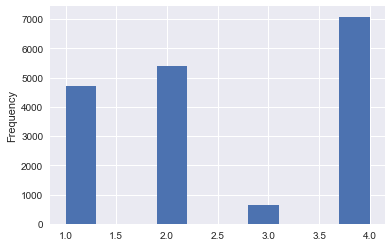

count    17833.000000
mean         2.565020
std          1.252428
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          4.000000
Name: F, dtype: float64

In [98]:
dataset['F'].plot(kind = 'hist')
plt.show()
dataset['F'].describe()

In [87]:
dataset['Frequency'].quantile(q=[0.25,0.5,0.75])

0.25    1.0
0.50    2.0
0.75    4.0
Name: Frequency, dtype: float64

In [88]:
dataset['Frequency'].describe()

count    5968.000000
mean        3.187668
std         4.341424
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       104.000000
Name: Frequency, dtype: float64

In [90]:
dataset[dataset['Frequency'] <= 1].shape

(2350, 112)

In [91]:
dataset[dataset['Frequency'] <= 2].shape

(3618, 112)

In [92]:
dataset[dataset['Frequency'] <= 4].shape

(4841, 112)

In [94]:
dataset.shape

(5968, 112)

In [152]:
dataset['Frequency'].plot(kind='box', notch = True)
plt.show()

KeyError: 'Frequency'

In [111]:
a = [0,1,2,3,4]
a = [0,0,0,0,4]
stats.percentileofscore(a, 2, kind='mean')

80.0

In [110]:
a = [0,0,0,0,4]
a.quantile(q=[0.25,0.5,0.75])

AttributeError: 'list' object has no attribute 'quantile'